# 6. 작사가 인공지능 만들기

|평가문항|상세기준|
|---|---|
|1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?|특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?|
|2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?|텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?|
|3. 텍스트 생성모델이 안정적으로 학습되었는가?|텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|

## 0. 라이브러리 호출 및 gpu 사용설정

In [20]:
import os, re 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import os
import random
from sklearn.model_selection import ParameterGrid,train_test_split

np.random.seed(1000)
tf.random.set_seed(1000)
random.seed(1000)

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7371487202872519544
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7691304960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5293912010572569439
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-04-09 20:20:55.807034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:55.845428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:55.845488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.436694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.436771: I tensorflow/compile

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-09 20:20:56.465867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.465961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.465995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.466255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 20:20:56.466290: I tensorflow/compile

## 1. 데이터 호출 및 전처리

In [4]:
txt_file_path = os.getcwd() +'/text/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
folder_path = os.getcwd() +'/'
raw_corpus=[]

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding='UTF8') as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Let's stay together I, I'm I'm so in love with you", 'Whatever you want to do', 'Is all right with me']


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

corpus[:10]

['<start> let s stay together i , i m i m so in love with you <end>',
 '<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> and i want to spend my life with you let me say that since , baby , since we ve been together <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>']

In [6]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    # 또한 토큰의 길이 15을 넘어가는 토큰은 학습에서 제외한다.
    tensor = tokenizer.texts_to_sequences(corpus) 
    tensor = [t for t in tensor if len(t) <= 15]
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
print(tensor.shape)

(156013, 15)


In [7]:
print(tensor[:3, :20])

[[  2 598   7  62  10  47   3   0   0   0   0   0   0   0   0]
 [  2  26  24  84  31  12   3   0   0   0   0   0   0   0   0]
 [  2  67   7  72  12 101  30 765 150   3   0   0   0   0   0]]


In [8]:
train_tensor,test_tensor=train_test_split(tensor,test_size=0.2, random_state=1000)

In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_train_input = train_tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_train_input = train_tensor[:, 1:]    

print(src_train_input[0])
print(tgt_train_input[0])

[   2 5911  107   48  172   41   38  144   14    6 1273    3    0    0]
[5911  107   48  172   41   38  144   14    6 1273    3    0    0    0]


In [10]:
src_test_input = test_tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_test_input = test_tensor[:, 1:]    

print(src_test_input[0])
print(tgt_test_input[0])

[ 2 81  1  4  1  4  8  1  3  0  0  0  0  0]
[81  1  4  1  4  8  1  3  0  0  0  0  0  0]


In [11]:
BUFFER_SIZE = len(src_train_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_train_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_train_input, tgt_train_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

In [12]:
BUFFER_SIZE = len(src_test_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_test_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset_val = tf.data.Dataset.from_tensor_slices((src_test_input, tgt_test_input))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
dataset_val

<_BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

## 2. 모델 작성 및 최적의 파라미터 찾기

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [14]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

2023-04-09 19:47:51.157018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [124810,14]
	 [[{{node Placeholder/_0}}]]
2023-04-09 19:47:52.648169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-04-09 19:47:53.522510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.81735031e-05,  6.22213247e-06,  1.89549010e-05, ...,
          1.46147686e-05,  9.90555709e-05,  6.11870273e-05],
        [ 2.24518633e-04,  1.28142434e-04, -1.28417814e-04, ...,
         -1.85586232e-05,  6.24269815e-05,  5.84678637e-05],
        [-2.07145349e-04,  2.86850089e-04, -1.30967921e-04, ...,
         -2.11471124e-04, -3.36193014e-04,  2.48072574e-05],
        ...,
        [-1.12198095e-03, -4.83330194e-04, -1.49487157e-03, ...,
          1.43465979e-04,  4.12778929e-04, -4.88189486e-04],
        [-1.05464505e-03, -4.34972579e-04, -1.89229671e-03, ...,
         -6.76558702e-05,  6.70484384e-04, -4.82758856e-04],
        [-1.18566188e-03, -4.24751051e-04, -2.00802158e-03, ...,
         -3.25275934e-04,  9.50945599e-04, -4.60758776e-04]],

       [[-1.81735031e-05,  6.22213247e-06,  1.89549010e-05, ...,
          1.46147686e-05,  9.90555709e-05,  6.11870273e-05],
        [ 7.68677201e-05, -4.64955338e-06,  2

In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  3072256   
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 lstm_1 (LSTM)               multiple                  8392704   
                                                                 
 dense (Dense)               multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = tf.keras.optimizers.legacy.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)

train_loss = []
test_loss =[]

# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

In [17]:
from sklearn.model_selection import ParameterSampler

# 먼저 랜덤서치를 이용하여 무작위의 파라미터를 사용하여 10번의 epoch를 학습시킨 후의 validation loss를 확인한다.

param_distributions = {'embedding_size': range(128,1025,128), 'hidden_size': range(256,2049,256)}
n_iter = 10
sampler = ParameterSampler(param_distributions, n_iter=n_iter)
val_loss_list = []
params_list = []

with tf.device("/device:GPU:0"):
    for params in sampler:
        if params in params_list:
            continue
        
        embedding_size = params['embedding_size']
        hidden_size = params['hidden_size']
        model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
        model.compile(loss=loss, optimizer=optimizer)
        hist = model.fit(dataset, epochs=10, validation_data=dataset_val, batch_size=64)
        params_list.append(params)
        val_loss_list.append(hist.history['val_loss'][-1])
            
posit=val_loss_list.index(min(val_loss_list))
print(f'Best parameters: {params_list[posit]}')
print(f'Best loss: {val_loss_list[posit]}')

Epoch 1/10


2023-04-09 18:37:26.661753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [124810,14]
	 [[{{node Placeholder/_0}}]]
2023-04-09 18:37:31.821252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:37:31.823076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

487/487 [==============================] - ETA: 0s - loss: 3.3381

2023-04-09 18:38:22.769353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [31203,14]
	 [[{{node Placeholder/_1}}]]
2023-04-09 18:38:22.912555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:38:22.913572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

487/487 [==============================] - 60s 100ms/step - loss: 3.3381 - val_loss: 2.9247
Epoch 2/10
487/487 [==============================] - 49s 100ms/step - loss: 2.7505 - val_loss: 2.6698
Epoch 3/10
487/487 [==============================] - 49s 100ms/step - loss: 2.4446 - val_loss: 2.4945
Epoch 4/10
487/487 [==============================] - 49s 101ms/step - loss: 2.1461 - val_loss: 2.3612
Epoch 5/10
487/487 [==============================] - 49s 101ms/step - loss: 1.8616 - val_loss: 2.2596
Epoch 6/10
487/487 [==============================] - 49s 101ms/step - loss: 1.6024 - val_loss: 2.1916
Epoch 7/10
487/487 [==============================] - 49s 101ms/step - loss: 1.3823 - val_loss: 2.1531
Epoch 8/10
487/487 [==============================] - 49s 101ms/step - loss: 1.2107 - val_loss: 2.1430
Epoch 9/10
487/487 [==============================] - 49s 101ms/step - loss: 1.0934 - val_loss: 2.1559
Epoch 10/10
487/487 [==============================] - 49s 101ms/step - loss: 1.0258

2023-04-09 18:45:49.605358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:45:49.606539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:45:49.607807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.3402

2023-04-09 18:46:02.196396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:46:02.197953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:46:02.198801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 14s 26ms/step - loss: 3.3402 - val_loss: 3.0420
Epoch 2/10
487/487 [==============================] - 12s 25ms/step - loss: 2.9463 - val_loss: 2.9294
Epoch 3/10
487/487 [==============================] - 12s 25ms/step - loss: 2.8346 - val_loss: 2.8544
Epoch 4/10
487/487 [==============================] - 12s 25ms/step - loss: 2.7475 - val_loss: 2.8011
Epoch 5/10
487/487 [==============================] - 12s 25ms/step - loss: 2.6730 - val_loss: 2.7540
Epoch 6/10
487/487 [==============================] - 12s 25ms/step - loss: 2.6060 - val_loss: 2.7140
Epoch 7/10
487/487 [==============================] - 12s 25ms/step - loss: 2.5425 - val_loss: 2.6825
Epoch 8/10
487/487 [==============================] - 12s 25ms/step - loss: 2.4821 - val_loss: 2.6518
Epoch 9/10
487/487 [==============================] - 12s 25ms/step - loss: 2.4245 - val_loss: 2.6287
Epoch 10/10
487/487 [==============================] - 12s 25ms/step - loss: 2.3692 - val_los

2023-04-09 18:47:54.195593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:47:54.197006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:47:54.198218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

486/487 [============================>.] - ETA: 0s - loss: 3.3762

2023-04-09 18:48:06.301252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:48:06.302882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:48:06.303924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 14s 25ms/step - loss: 3.3756 - val_loss: 3.0626
Epoch 2/10
487/487 [==============================] - 12s 24ms/step - loss: 2.9648 - val_loss: 2.9444
Epoch 3/10
487/487 [==============================] - 12s 24ms/step - loss: 2.8578 - val_loss: 2.8757
Epoch 4/10
487/487 [==============================] - 12s 24ms/step - loss: 2.7783 - val_loss: 2.8224
Epoch 5/10
487/487 [==============================] - 12s 24ms/step - loss: 2.7107 - val_loss: 2.7826
Epoch 6/10
487/487 [==============================] - 12s 24ms/step - loss: 2.6498 - val_loss: 2.7441
Epoch 7/10
487/487 [==============================] - 12s 24ms/step - loss: 2.5916 - val_loss: 2.7121
Epoch 8/10
487/487 [==============================] - 12s 24ms/step - loss: 2.5348 - val_loss: 2.6797
Epoch 9/10
487/487 [==============================] - 12s 24ms/step - loss: 2.4817 - val_loss: 2.6546
Epoch 10/10
487/487 [==============================] - 12s 24ms/step - loss: 2.4292 - val_los

2023-04-09 18:49:53.659955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:49:53.661748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:49:53.663014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.4574

2023-04-09 18:50:05.214518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:50:05.215561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:50:05.217051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 13s 24ms/step - loss: 3.4574 - val_loss: 3.1314
Epoch 2/10
487/487 [==============================] - 11s 23ms/step - loss: 3.0248 - val_loss: 2.9909
Epoch 3/10
487/487 [==============================] - 11s 23ms/step - loss: 2.9058 - val_loss: 2.9158
Epoch 4/10
487/487 [==============================] - 11s 23ms/step - loss: 2.8251 - val_loss: 2.8628
Epoch 5/10
487/487 [==============================] - 11s 23ms/step - loss: 2.7575 - val_loss: 2.8176
Epoch 6/10
487/487 [==============================] - 11s 23ms/step - loss: 2.6974 - val_loss: 2.7790
Epoch 7/10
487/487 [==============================] - 11s 23ms/step - loss: 2.6410 - val_loss: 2.7461
Epoch 8/10
487/487 [==============================] - 11s 23ms/step - loss: 2.5873 - val_loss: 2.7181
Epoch 9/10
487/487 [==============================] - 11s 23ms/step - loss: 2.5365 - val_loss: 2.6922
Epoch 10/10
487/487 [==============================] - 11s 23ms/step - loss: 2.4864 - val_los

2023-04-09 18:51:50.319779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:51:50.321191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:51:50.322926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.7684

2023-04-09 18:52:32.535184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:52:32.536613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:52:32.537762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 48s 85ms/step - loss: 3.7684 - val_loss: 3.5180
Epoch 2/10
487/487 [==============================] - 41s 85ms/step - loss: 3.4387 - val_loss: 3.4252
Epoch 3/10
487/487 [==============================] - 42s 85ms/step - loss: 3.3372 - val_loss: 3.3441
Epoch 4/10
487/487 [==============================] - 41s 85ms/step - loss: 3.2435 - val_loss: 3.2543
Epoch 5/10
487/487 [==============================] - 42s 85ms/step - loss: 3.1467 - val_loss: 3.1695
Epoch 6/10
487/487 [==============================] - 42s 85ms/step - loss: 3.0507 - val_loss: 3.1009
Epoch 7/10
487/487 [==============================] - 42s 85ms/step - loss: 2.9787 - val_loss: 3.0547
Epoch 8/10
487/487 [==============================] - 41s 85ms/step - loss: 2.9235 - val_loss: 3.0215
Epoch 9/10
487/487 [==============================] - 41s 85ms/step - loss: 2.8743 - val_loss: 2.9926
Epoch 10/10
487/487 [==============================] - 40s 81ms/step - loss: 2.8287 - val_los

2023-04-09 18:58:48.931447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:58:48.933018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:58:48.933943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

486/487 [============================>.] - ETA: 0s - loss: 3.2374

2023-04-09 18:59:07.192059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 18:59:07.193130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 18:59:07.194408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 21s 37ms/step - loss: 3.2366 - val_loss: 2.9216
Epoch 2/10
487/487 [==============================] - 18s 36ms/step - loss: 2.7971 - val_loss: 2.7791
Epoch 3/10
487/487 [==============================] - 18s 36ms/step - loss: 2.6314 - val_loss: 2.6886
Epoch 4/10
487/487 [==============================] - 18s 36ms/step - loss: 2.4916 - val_loss: 2.6204
Epoch 5/10
487/487 [==============================] - 18s 36ms/step - loss: 2.3666 - val_loss: 2.5626
Epoch 6/10
487/487 [==============================] - 18s 36ms/step - loss: 2.2495 - val_loss: 2.5174
Epoch 7/10
487/487 [==============================] - 18s 36ms/step - loss: 2.1386 - val_loss: 2.4749
Epoch 8/10
487/487 [==============================] - 18s 36ms/step - loss: 2.0336 - val_loss: 2.4433
Epoch 9/10
487/487 [==============================] - 18s 36ms/step - loss: 1.9331 - val_loss: 2.4157
Epoch 10/10
487/487 [==============================] - 18s 36ms/step - loss: 1.8379 - val_los

2023-04-09 19:01:49.057051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:01:49.058542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:01:49.059751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

485/487 [============================>.] - ETA: 0s - loss: 3.6112

2023-04-09 19:01:57.149091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:01:57.150145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:01:57.151136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 9s 16ms/step - loss: 3.6099 - val_loss: 3.3318
Epoch 2/10
487/487 [==============================] - 8s 15ms/step - loss: 3.1885 - val_loss: 3.1220
Epoch 3/10
487/487 [==============================] - 8s 15ms/step - loss: 3.0493 - val_loss: 3.0442
Epoch 4/10
487/487 [==============================] - 8s 15ms/step - loss: 2.9772 - val_loss: 2.9953
Epoch 5/10
487/487 [==============================] - 8s 15ms/step - loss: 2.9194 - val_loss: 2.9486
Epoch 6/10
487/487 [==============================] - 8s 15ms/step - loss: 2.8637 - val_loss: 2.9040
Epoch 7/10
487/487 [==============================] - 8s 15ms/step - loss: 2.8105 - val_loss: 2.8680
Epoch 8/10
487/487 [==============================] - 8s 15ms/step - loss: 2.7623 - val_loss: 2.8335
Epoch 9/10
487/487 [==============================] - 8s 15ms/step - loss: 2.7169 - val_loss: 2.8050
Epoch 10/10
487/487 [==============================] - 8s 15ms/step - loss: 2.6731 - val_loss: 2.7773


2023-04-09 19:03:08.999064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:03:09.000813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:03:09.001734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.5342

2023-04-09 19:03:48.707056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:03:48.708066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:03:48.709702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 46s 80ms/step - loss: 3.5342 - val_loss: 3.1767
Epoch 2/10
487/487 [==============================] - 39s 79ms/step - loss: 3.0387 - val_loss: 2.9746
Epoch 3/10
487/487 [==============================] - 39s 79ms/step - loss: 2.8580 - val_loss: 2.8551
Epoch 4/10
487/487 [==============================] - 39s 80ms/step - loss: 2.7185 - val_loss: 2.7669
Epoch 5/10
487/487 [==============================] - 39s 79ms/step - loss: 2.5952 - val_loss: 2.6959
Epoch 6/10
487/487 [==============================] - 39s 79ms/step - loss: 2.4800 - val_loss: 2.6393
Epoch 7/10
487/487 [==============================] - 39s 79ms/step - loss: 2.3714 - val_loss: 2.5945
Epoch 8/10
487/487 [==============================] - 39s 79ms/step - loss: 2.2697 - val_loss: 2.5550
Epoch 9/10
487/487 [==============================] - 39s 79ms/step - loss: 2.1728 - val_loss: 2.5230
Epoch 10/10
487/487 [==============================] - 39s 79ms/step - loss: 2.0780 - val_los

2023-04-09 19:09:41.308497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:09:41.310086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:09:41.311046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.3619

2023-04-09 19:09:56.774335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:09:56.775754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:09:56.776802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 17s 32ms/step - loss: 3.3619 - val_loss: 3.0945
Epoch 2/10
487/487 [==============================] - 15s 31ms/step - loss: 2.9910 - val_loss: 2.9699
Epoch 3/10
487/487 [==============================] - 15s 31ms/step - loss: 2.8746 - val_loss: 2.8878
Epoch 4/10
487/487 [==============================] - 15s 31ms/step - loss: 2.7841 - val_loss: 2.8316
Epoch 5/10
487/487 [==============================] - 15s 31ms/step - loss: 2.7076 - val_loss: 2.7854
Epoch 6/10
487/487 [==============================] - 15s 31ms/step - loss: 2.6388 - val_loss: 2.7499
Epoch 7/10
487/487 [==============================] - 15s 31ms/step - loss: 2.5751 - val_loss: 2.7098
Epoch 8/10
487/487 [==============================] - 15s 31ms/step - loss: 2.5142 - val_loss: 2.6836
Epoch 9/10
487/487 [==============================] - 15s 31ms/step - loss: 2.4555 - val_loss: 2.6568
Epoch 10/10
487/487 [==============================] - 15s 31ms/step - loss: 2.3985 - val_los

2023-04-09 19:12:14.724687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:12:14.725801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:12:14.727379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.4031

2023-04-09 19:12:25.809447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:12:25.811129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:12:25.812279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 13s 23ms/step - loss: 3.4031 - val_loss: 3.0821
Epoch 2/10
487/487 [==============================] - 11s 22ms/step - loss: 2.9782 - val_loss: 2.9522
Epoch 3/10
487/487 [==============================] - 11s 22ms/step - loss: 2.8660 - val_loss: 2.8801
Epoch 4/10
487/487 [==============================] - 11s 22ms/step - loss: 2.7838 - val_loss: 2.8255
Epoch 5/10
487/487 [==============================] - 11s 22ms/step - loss: 2.7146 - val_loss: 2.7833
Epoch 6/10
487/487 [==============================] - 11s 22ms/step - loss: 2.6524 - val_loss: 2.7438
Epoch 7/10
487/487 [==============================] - 11s 22ms/step - loss: 2.5951 - val_loss: 2.7151
Epoch 8/10
487/487 [==============================] - 11s 22ms/step - loss: 2.5408 - val_loss: 2.6864
Epoch 9/10
487/487 [==============================] - 11s 22ms/step - loss: 2.4875 - val_loss: 2.6625
Epoch 10/10
487/487 [==============================] - 11s 22ms/step - loss: 2.4351 - val_los

랜덤서치를 실행한 결과 다음과 같은 결과를 얻었다.

Best parameters: {'hidden_size': 2048, 'embedding_size': 512}  
Best loss: 2.177577495574951

해당 파라미터의 주변을 다시한번 그리드 서치를 이용하여 탐색한다.

In [19]:
param_grid = {'embedding_size': [384,512,640], 'hidden_size': [1792, 2048, 2304]}
grid = ParameterGrid(param_grid)

best_val_loss = float('inf')
best_params = None

with tf.device("/device:GPU:0"):
    for params in grid:
        embedding_size = params['embedding_size']
        hidden_size = params['hidden_size']
        model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
        model.compile(loss=loss, optimizer=optimizer) 
        hist = model.fit(dataset, epochs=10, validation_data=dataset_val, batch_size=64)
        val_loss = hist.history['val_loss'][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params

print(f'Best parameters: {best_params}')
print(f'Best loss: {best_val_loss}')

Epoch 1/10


2023-04-09 19:22:06.081038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:22:06.082792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:22:06.084145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.7923

2023-04-09 19:22:48.629340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:22:48.630721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:22:48.631576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 49s 87ms/step - loss: 3.7923 - val_loss: 3.4625
Epoch 2/10
487/487 [==============================] - 42s 85ms/step - loss: 3.3833 - val_loss: 3.3924
Epoch 3/10
487/487 [==============================] - 41s 85ms/step - loss: 3.3005 - val_loss: 3.3360
Epoch 4/10
487/487 [==============================] - 42s 85ms/step - loss: 3.2253 - val_loss: 3.2605
Epoch 5/10
487/487 [==============================] - 42s 86ms/step - loss: 3.1166 - val_loss: 3.1805
Epoch 6/10
487/487 [==============================] - 42s 85ms/step - loss: 3.0105 - val_loss: 3.1077
Epoch 7/10
487/487 [==============================] - 42s 86ms/step - loss: 2.9632 - val_loss: 3.1009
Epoch 8/10
487/487 [==============================] - 42s 85ms/step - loss: 2.9388 - val_loss: 3.0299
Epoch 9/10
487/487 [==============================] - 42s 85ms/step - loss: 2.9159 - val_loss: 3.0021
Epoch 10/10
487/487 [==============================] - 42s 85ms/step - loss: 2.8416 - val_los

2023-04-09 19:29:12.308444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:29:12.309762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:29:12.310768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.7624

2023-04-09 19:30:03.581926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:30:03.583069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:30:03.584088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 60s 101ms/step - loss: 3.7624 - val_loss: 3.4408
Epoch 2/10
487/487 [==============================] - 49s 99ms/step - loss: 3.4779 - val_loss: 3.4058
Epoch 3/10
487/487 [==============================] - 48s 99ms/step - loss: 3.3061 - val_loss: 3.3087
Epoch 4/10
487/487 [==============================] - 49s 100ms/step - loss: 3.2298 - val_loss: 3.2524
Epoch 5/10
487/487 [==============================] - 49s 100ms/step - loss: 3.1713 - val_loss: 3.2484
Epoch 6/10
487/487 [==============================] - 49s 100ms/step - loss: 3.1124 - val_loss: 3.1286
Epoch 7/10
487/487 [==============================] - 49s 99ms/step - loss: 3.0080 - val_loss: 3.0731
Epoch 8/10
487/487 [==============================] - 49s 99ms/step - loss: 2.9354 - val_loss: 3.0305
Epoch 9/10
487/487 [==============================] - 49s 99ms/step - loss: 2.8741 - val_loss: 2.9936
Epoch 10/10
487/487 [==============================] - 49s 100ms/step - loss: 2.8165 - va

2023-04-09 19:37:30.669619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:37:30.671230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:37:30.672173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

InternalError: Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 384, 2304, 1, 14, 256, 2304] 
	 [[{{node CudnnRNN}}]]
	 [[text_generator_14/lstm_28/PartitionedCall]] [Op:__inference_train_function_291208]

In [20]:
posit=val_loss_list.index(min(val_loss_list))
print(f'Best parameters: {params_list[posit]}')
print(f'Best loss: {val_loss_list[posit]}')

Best parameters: {'hidden_size': 2048, 'embedding_size': 512}
Best loss: 2.177577495574951


그리드 서치를 실시하는 과정에서 메모리 사용량 과다로 인하여 오류를 출력하였고 도중에 그리드서치가 멈추었다.  
하지만 그리드서치가 멈추기 전까지의 loss들 중에서 가장 작은 값을 같는것은 이전과 같이 아래의 파라미터임을 알 수 있었다.

Best parameters: {'hidden_size': 2048, 'embedding_size': 512}  
Best loss: 2.177577495574951

따라서 해당 파라미터를 이용하여 학습을 진행하고 문장 생성을 실시하도록 한다.

## 3. 모델 생성 및 문장 생성

In [18]:
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
with tf.device("/device:GPU:0"):
    hist=model.fit(dataset, epochs=30, batch_size=64, validation_data = dataset_val, verbose=1) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])

Epoch 1/30


2023-04-09 19:48:38.814499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:48:38.817119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 19:48:38.819689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.2974

2023-04-09 19:49:36.506029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [31203,14]
	 [[{{node Placeholder/_1}}]]
2023-04-09 19:49:36.649304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 19:49:36.650387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

487/487 [==============================] - 67s 112ms/step - loss: 3.2974 - val_loss: 2.9104
Epoch 2/30
487/487 [==============================] - 50s 103ms/step - loss: 2.7368 - val_loss: 2.6514
Epoch 3/30
487/487 [==============================] - 50s 102ms/step - loss: 2.4071 - val_loss: 2.4648
Epoch 4/30
487/487 [==============================] - 50s 102ms/step - loss: 2.0858 - val_loss: 2.3271
Epoch 5/30
487/487 [==============================] - 50s 102ms/step - loss: 1.7867 - val_loss: 2.2328
Epoch 6/30
487/487 [==============================] - 50s 103ms/step - loss: 1.5276 - val_loss: 2.1727
Epoch 7/30
487/487 [==============================] - 49s 101ms/step - loss: 1.3208 - val_loss: 2.1469
Epoch 8/30
487/487 [==============================] - 50s 102ms/step - loss: 1.1692 - val_loss: 2.1488
Epoch 9/30
487/487 [==============================] - 49s 101ms/step - loss: 1.0718 - val_loss: 2.1656
Epoch 10/30
487/487 [==============================] - 49s 100ms/step - loss: 1.0184

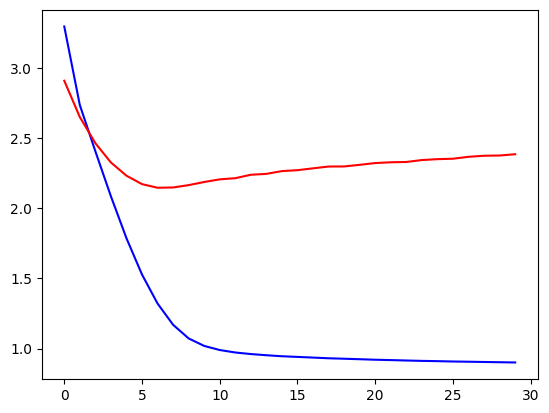

In [19]:
train_loss=np.array(train_loss)
test_loss=np.array(test_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
test_loss=test_loss.reshape(test_loss.shape[0]*test_loss.shape[1],1)
plt.plot(train_loss,color="blue")
plt.plot(test_loss,color="red")

위의 그래프를 보게되면 test_loss는 꾸준히 감소하지만 val_loss는 7 epoch를 기준으로 점점 증가하는 것을 알 수 있다.  
이는 모델의 과적합으로 인한 것으로 예상되기 때문에 모델의 과적합을 피하기 위하여 drop out 코드를 추가하여 새로 학습을 시켜보기로 한다.

In [29]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.dropout_1 = tf.keras.layers.Dropout(0.2)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout_2 = tf.keras.layers.Dropout(0.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout_1(out)
        out = self.rnn_2(out)
        out = self.dropout_2(out)
        out = self.linear(out)
        
        return out

train_loss = []
test_loss =[]

embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [30]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
with tf.device("/device:GPU:0"):
    hist=model.fit(dataset, epochs=15, batch_size=64, validation_data = dataset_val, verbose=1) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])

Epoch 1/15


2023-04-09 20:59:25.014380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 20:59:25.016169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 20:59:25.017609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.3114

2023-04-09 21:00:23.829594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 21:00:23.830935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 21:00:23.831947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 69s 117ms/step - loss: 3.3114 - val_loss: 2.9567
Epoch 2/15
487/487 [==============================] - 55s 113ms/step - loss: 2.8173 - val_loss: 2.7341
Epoch 3/15
487/487 [==============================] - 56s 115ms/step - loss: 2.5699 - val_loss: 2.5675
Epoch 4/15
487/487 [==============================] - 56s 114ms/step - loss: 2.3333 - val_loss: 2.4375
Epoch 5/15
487/487 [==============================] - 56s 114ms/step - loss: 2.1063 - val_loss: 2.3357
Epoch 6/15
487/487 [==============================] - 56s 115ms/step - loss: 1.8973 - val_loss: 2.2553
Epoch 7/15
487/487 [==============================] - 56s 115ms/step - loss: 1.7117 - val_loss: 2.2017
Epoch 8/15
487/487 [==============================] - 56s 114ms/step - loss: 1.5548 - val_loss: 2.1657
Epoch 9/15
487/487 [==============================] - 56s 114ms/step - loss: 1.4249 - val_loss: 2.1432
Epoch 10/15
487/487 [==============================] - 56s 114ms/step - loss: 1.3197

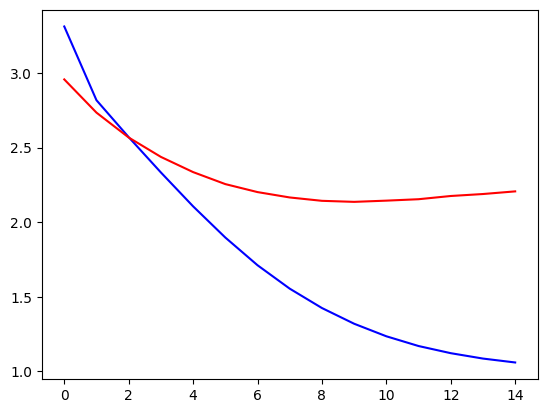

In [31]:
train_loss=np.array(train_loss)
test_loss=np.array(test_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
test_loss=test_loss.reshape(test_loss.shape[0]*test_loss.shape[1],1)
plt.plot(train_loss,color="blue")
plt.plot(test_loss,color="red")

test 결과 val_loss가 증가하는 지점이 조금 늦어져서 10 epoch에서 점점 증가하는 경향을 보인다.  
하지만 val_loss의 최저점 자체는 이전과 크게 차이가 나지 않는 것을 보인다.  
따라서 원래 모델의 7 epoch까지만 학습을 실시하고, 해당 모델을 이용해서 문장을 생성하도록 한다.

In [34]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [35]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
with tf.device("/device:GPU:0"):
    hist=model.fit(dataset, epochs=7, batch_size=64, validation_data = dataset_val, verbose=1) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/7


2023-04-09 21:16:53.368691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 21:16:53.370658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 21:16:53.371853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - ETA: 0s - loss: 3.2710

2023-04-09 21:17:48.504022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 21:17:48.505888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 21:17:48.507071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

487/487 [==============================] - 64s 108ms/step - loss: 3.2710 - val_loss: 2.9037
Epoch 2/7
487/487 [==============================] - 52s 107ms/step - loss: 2.7288 - val_loss: 2.6537
Epoch 3/7
487/487 [==============================] - 52s 106ms/step - loss: 2.4212 - val_loss: 2.4775
Epoch 4/7
487/487 [==============================] - 52s 107ms/step - loss: 2.1204 - val_loss: 2.3437
Epoch 5/7
487/487 [==============================] - 50s 102ms/step - loss: 1.8353 - val_loss: 2.2472
Epoch 6/7
487/487 [==============================] - 51s 103ms/step - loss: 1.5774 - val_loss: 2.1808
Epoch 7/7
487/487 [==============================] - 51s 104ms/step - loss: 1.3644 - val_loss: 2.1474


In [36]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [77]:
lyric="<start> i love"

lyric= generate_text(model, tokenizer, init_sentence=lyric, max_len=20)
lyric

'<start> i love you liberian girl , <end> '

위와 같이 문제 없이 문장이 작성 되는 것을 알 수 있다.  
다행히 가지고있는 gpu의 성능이 나쁘지는 않아서 학습하는데 걸리는 시간을 대폭 단축 시킬수 있었으나, 그럼에도 불구하고 학습하는데 많은 시간을 투자해야 했다.  
만약 시간이 조금 더 적게 걸리거나 했더라면 좀 더 다양한 방법으로 시도해 볼 수 있었겠지만 그러지 못한점은 아쉽다.